In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Embedding, LSTM, Dropout, MultiHeadAttention
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import io
#from google.colab import files
#uploaded = files.upload()
#df = pd.read_excel(io.BytesIO(uploaded['bela.xlsx']))

In [ ]:
# Specify the path to your data file on Google Drive
#file_path = '/content/MyDrive/Colab Notebooks/bela.xlsx'
file_path = '/content/drive/MyDrive/Colab Notebooks/urdu embedding test data.xlsx'
# Load data into Pandas DataFrame
df = pd.read_excel(file_path)

# Display the loaded data
print(df.head())

   Unnamed: 0                                               Text  Label
0           0   ہو لینے دے میری شادی فسادن ٹھیک ہے کوجی نہیں ...      1
1           1  چل مہمانوں میں کھانا سرو کر چڑیل چاچی نوں دسدی...      1
2           2  کامران خان آپکی دن بھریہ زمہ داری لگائی گئی اپ...      0
3           3                                        نہیں پائین       0
4           4   `` مراد علی شاہ کے بھیس میں ڈی جی آئی ایس آئی...      1


In [ ]:
# Assign text and labels to variables
X = df['Text'].values
y = df['Label'].values

# Convert float values to string
X = [str(x) for x in X]

# Tokenize the words
tokenizer = Tokenizer(num_words=10000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)

# Pad the sequences to a fixed length
max_length = 50
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Reshape your labels to match the model's output shape
y_train = np.reshape(y_train, (-1, 1))
y_val = np.reshape(y_val, (-1, 1))



In [ ]:
# Define MultiHeadAttentionLayer before using it in the model
class MultiHeadAttentionLayer(Layer):
    def __init__(self, num_heads=8, key_dim=64):
        super(MultiHeadAttentionLayer, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, inputs):
        query = inputs
        key = inputs
        value = inputs
        attention_output = self.multi_head_attention(query, key, value)
        return attention_output


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(units=64)),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=32, activation='tanh'),
    Dense(units=1, activation='sigmoid')
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=128, callbacks=[early_stopping], verbose=1)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 64)            640000    
                                                                 
 bidirectional_20 (Bidirect  (None, 50, 256)           197632    
 ional)                                                          
                                                                 
 dropout_19 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_21 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)               

In [ ]:
from tensorflow.keras.models import save_model
import os

# Set the directory where you want to save the model
# Make sure to replace 'path_to_directory' with the desired path
save_dir = '/content/drive/MyDrive/Colab Notebook'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define the model name
model_name = "my_improved_model.h5"

# Save the model in the specified directory
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

print(f"Model saved successfully as {model_path}")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully as /content/drive/MyDrive/Colab Notebook/my_improved_model.h5


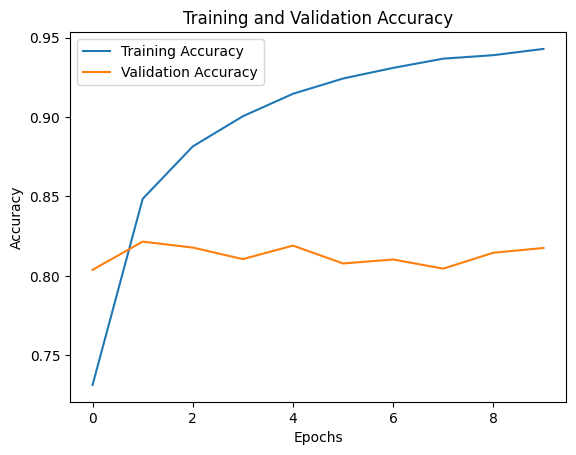

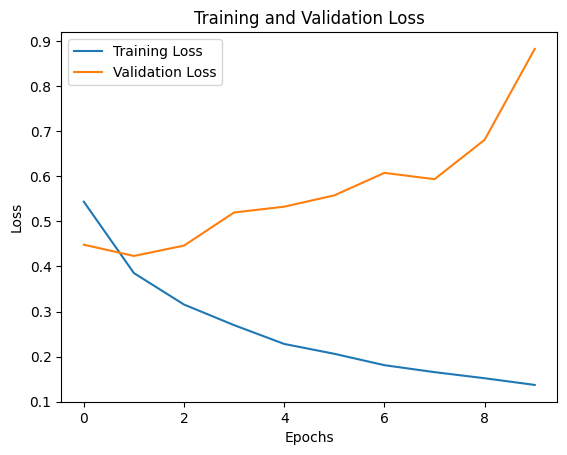

In [ ]:
import matplotlib.pyplot as plt
# Visualize training results - accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize training results - loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Ensure predicted probabilities
y_pred_prob = model.predict(X_val)

# Ensure predicted labels are within the range of 0 and 1
y_pred = np.squeeze(np.where(y_pred_prob > 0.5, 1, 0))

# Ensure shapes of predicted labels and true labels match
y_val = np.squeeze(y_val)  # Ensure y_val is one-dimensional

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Print training loss
print("Training Loss:", history.history['loss'])

126/126 [==============================] - 11s 70ms/step
Accuracy: 0.8215446138465383
Precision: 0.7884980988593155
Recall: 0.8604771784232366
F1-score: 0.8229166666666666
Training Loss: [0.5434296727180481, 0.38517236709594727, 0.31537047028541565, 0.2697332799434662, 0.22806492447853088, 0.20621533691883087, 0.1809745728969574, 0.1655423939228058, 0.15201972424983978, 0.13722027838230133]


In [ ]:
# # Predict on the validation set
# import io
# from google.colab import files
# import seaborn as sns
# import matplotlib.pyplot as plt
# # Import the necessary libraries
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# y_pred_prob = model.predict(X_val)
# y_pred = np.where(y_pred_prob > 0.5, 1, 0)
# print(y_val,y_pred)
# # Create a confusion matrix
# cm = confusion_matrix(y_val, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # Ensure predicted labels are within the range of 0 and 1
# #y_pred = np.squeeze(np.where(y_pred_prob > 0.5, 1, 0))  # Ensure y_pred is binary (0 or 1)

# # Ensure shapes of predicted labels and true labels match
# y_val = np.squeeze(y_val)  # Ensure y_val is one-dimensional

# # Calculate evaluation metrics
# accuracy = accuracy_score(y_val, y_pred)
# precision = precision_score(y_val, y_pred)
# recall = recall_score(y_val, y_pred)
# f1 = f1_score(y_val, y_pred)

# # Print the evaluation metrics
# print("Evaluation Metrics:")
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)
